In [ ]:
import os
import sys
import cv2
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Conv2D, Flatten, Activation,
                                     Dropout, MaxPooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from IPython.display import clear_output

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Dataset/docs-data.zip'
clear_output()

In [ ]:
print(f'Python version {sys.version}')
print(f'Scikit-learn version {sklearn.__version__}')
print(f'Tensorflow version {tf.__version__}')

Python version 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Scikit-learn version 1.2.2
Tensorflow version 2.12.0


In [ ]:
dataset_path_img = '/content/training/images'
dataset_path_metadata = '/content/training/metadata.csv'

random_state = 42

In [ ]:
df = pd.read_csv(dataset_path_metadata)
df = df.sample(frac=1, ignore_index=True, random_state=random_state)
df.head()

,image,label
0,66_Fixal.png,Tab. Fixal 120mg
1,2_Relaxo.png,Tab. Relaxo 25mg
2,4_Ovocal-DX.png,Tab. Ovocal-DX
3,27_Sergel.png,Cap. Sergel 20mg
4,33_Finix.png,Tab. Finix 20mg


In [ ]:
df.shape

(1709, 2)

In [ ]:
def count_samples(df: pd.DataFrame, title: str='', is_save: bool=False) -> None:
    plt.figure(figsize=(15, 8))
    sns.countplot(x=df['label'], palette=['#432371',"#FAAE7B"])
    if title != '':
        plt.title(title)
    plt.xlabel('Medicine classes')
    plt.ylabel('Number of samples')
    plt.xticks(rotation=20, ha='right')
    if is_save:
        plt.savefig('./number-of-samples.png', dpi=300)
    plt.show()

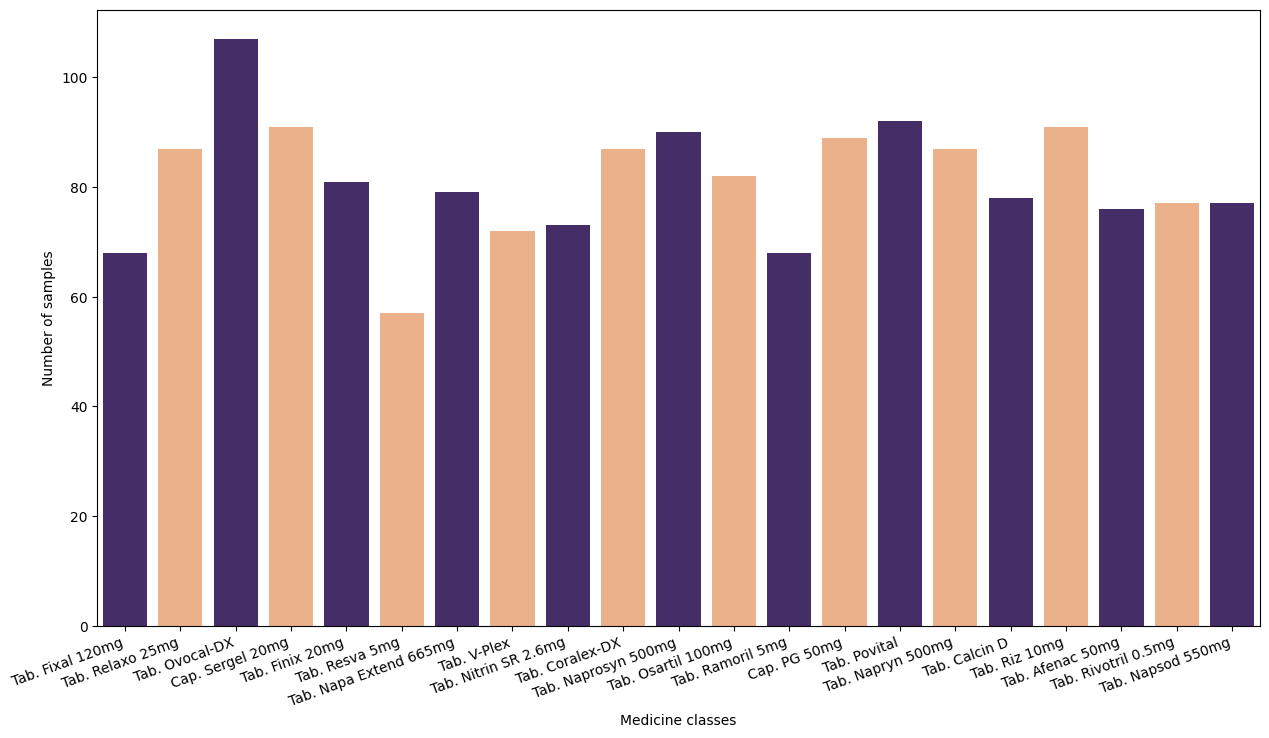

In [ ]:
count_samples(df, '', True)

In [ ]:
train_dataframe = df.sample(frac=0.8, random_state=random_state)
train_indices = train_dataframe.index

excluding_indices = df.index.isin(train_indices)
test_dataframe = df[~excluding_indices]

print('--Train--')
print(train_dataframe.head())
print(train_dataframe.shape)
print('--Test--')
print(test_dataframe.head())
print(test_dataframe.shape)

--Train--
               image                 label
567         8_SR.png  Tab. Nitrin SR 2.6mg
1326   66_Sergel.png      Cap. Sergel 20mg
1061    38_Fixal.png      Tab. Fixal 120mg
115    36_Napsod.png     Tab. Napsod 550mg
453   71_Osartil.png    Tab. Osartil 100mg
(1367, 2)
--Test--
             image               label
1     2_Relaxo.png    Tab. Relaxo 25mg
8    58_V-Plex.png         Tab. V-Plex
13   7_Osartil.png  Tab. Osartil 100mg
14  61_Ramoril.png    Tab. Ramoril 5mg
20  68_Povital.png        Tab. Povital
(342, 2)


In [ ]:
IMG_W = 256
IMG_H = 72
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50
NO_CLASSES = 21
N_FOLD_SIZE = 5

input_shape = (IMG_H, IMG_W, CHANNELS)

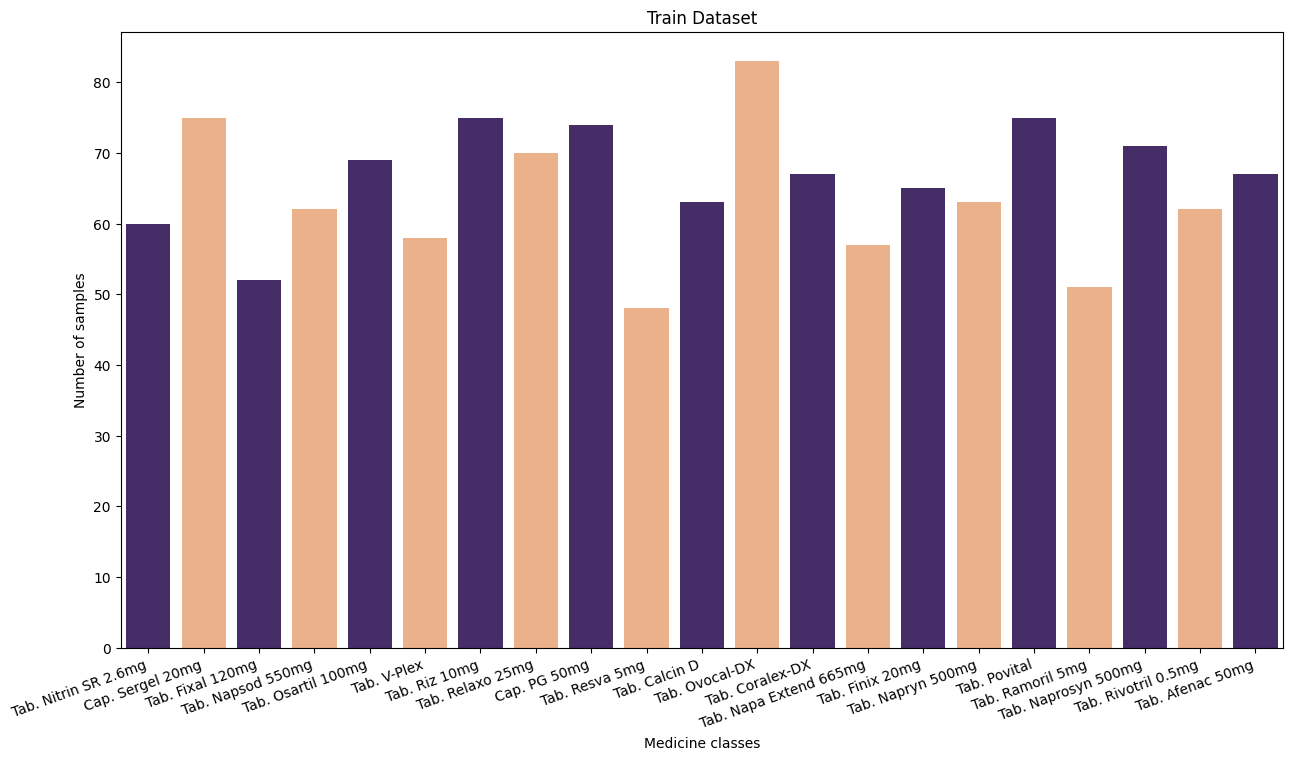

In [ ]:
count_samples(train_dataframe, 'Train Dataset')

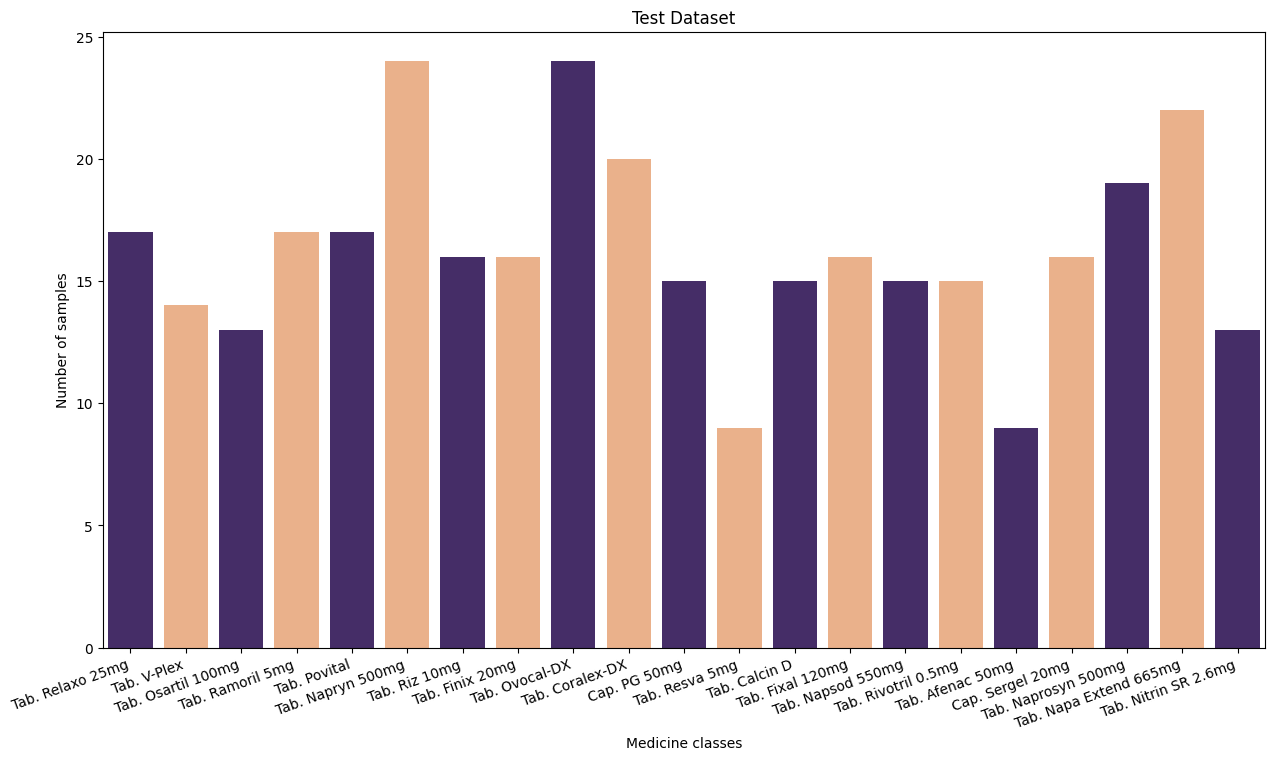

In [ ]:
count_samples(test_dataframe, 'Test Dataset')

In [ ]:
def plot_accuracy(history, kth=0, model_name=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(25, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(50), acc, label='Training Accuracy')
    plt.plot(range(50), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(
        f'Training and Validation Accuracy {f"for {model_name}" if model_name else ""}')

    plt.subplot(1, 2, 2)
    plt.plot(range(50), loss, label='Training Loss')
    plt.plot(range(50), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(
        f'Training and Validation Loss {f"for {model_name}" if model_name else ""}')
    plt.savefig(f'/content/model_accuracy-{kth}.png')
    plt.show()

In [ ]:
def create_model(no_classes):
    model = Sequential([
        # Conv 1
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        # Conv 2
        Conv2D(64,  kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        # Conv 3
        Conv2D(96,  kernel_size=(4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Conv 4
        Conv2D(96, (4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        # Conv 5
        Conv2D(128, (4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        # Conv 6
        Conv2D(128, (4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(no_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

## Dataset Generation and Model Training

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_set = datagen.flow_from_dataframe(dataframe=test_dataframe,
            directory=dataset_path_img,
            x_col='image', y_col='label',
            class_mode='categorical',
            target_size=(IMG_H, IMG_W),
            batch_size=BATCH_SIZE)

Found 342 validated image filenames belonging to 21 classes.


In [ ]:
X = train_dataframe.drop('label', axis=1)
Y = train_dataframe[['label']]

In [ ]:
kfold = StratifiedKFold(n_splits=N_FOLD_SIZE, shuffle=True, random_state=random_state)

In [ ]:
fold_no = 1
acc_per_fold = []

Fold No. 1
Found 1093 validated image filenames belonging to 21 classes.
Found 274 validated image filenames belonging to 21 classes.
Epoch 1/50
35/35 [==============================] - 22s 91ms/step - loss: 3.0502 - accuracy: 0.0430 - val_loss: 3.0426 - val_accuracy: 0.0547
Epoch 2/50
35/35 [==============================] - 2s 53ms/step - loss: 3.0424 - accuracy: 0.0503 - val_loss: 3.0413 - val_accuracy: 0.0584
Epoch 3/50
35/35 [==============================] - 2s 66ms/step - loss: 3.0371 - accuracy: 0.0558 - val_loss: 3.0314 - val_accuracy: 0.0547
Epoch 4/50
35/35 [==============================] - 2s 70ms/step - loss: 2.9360 - accuracy: 0.0833 - val_loss: 2.7361 - val_accuracy: 0.1642
Epoch 5/50
35/35 [==============================] - 2s 52ms/step - loss: 2.5449 - accuracy: 0.1839 - val_loss: 2.3999 - val_accuracy: 0.2993
Epoch 6/50
35/35 [==============================] - 2s 51ms/step - loss: 2.1965 - accuracy: 0.2919 - val_loss: 2.1100 - val_accuracy: 0.3212
Epoch 7/50
35/35 [=

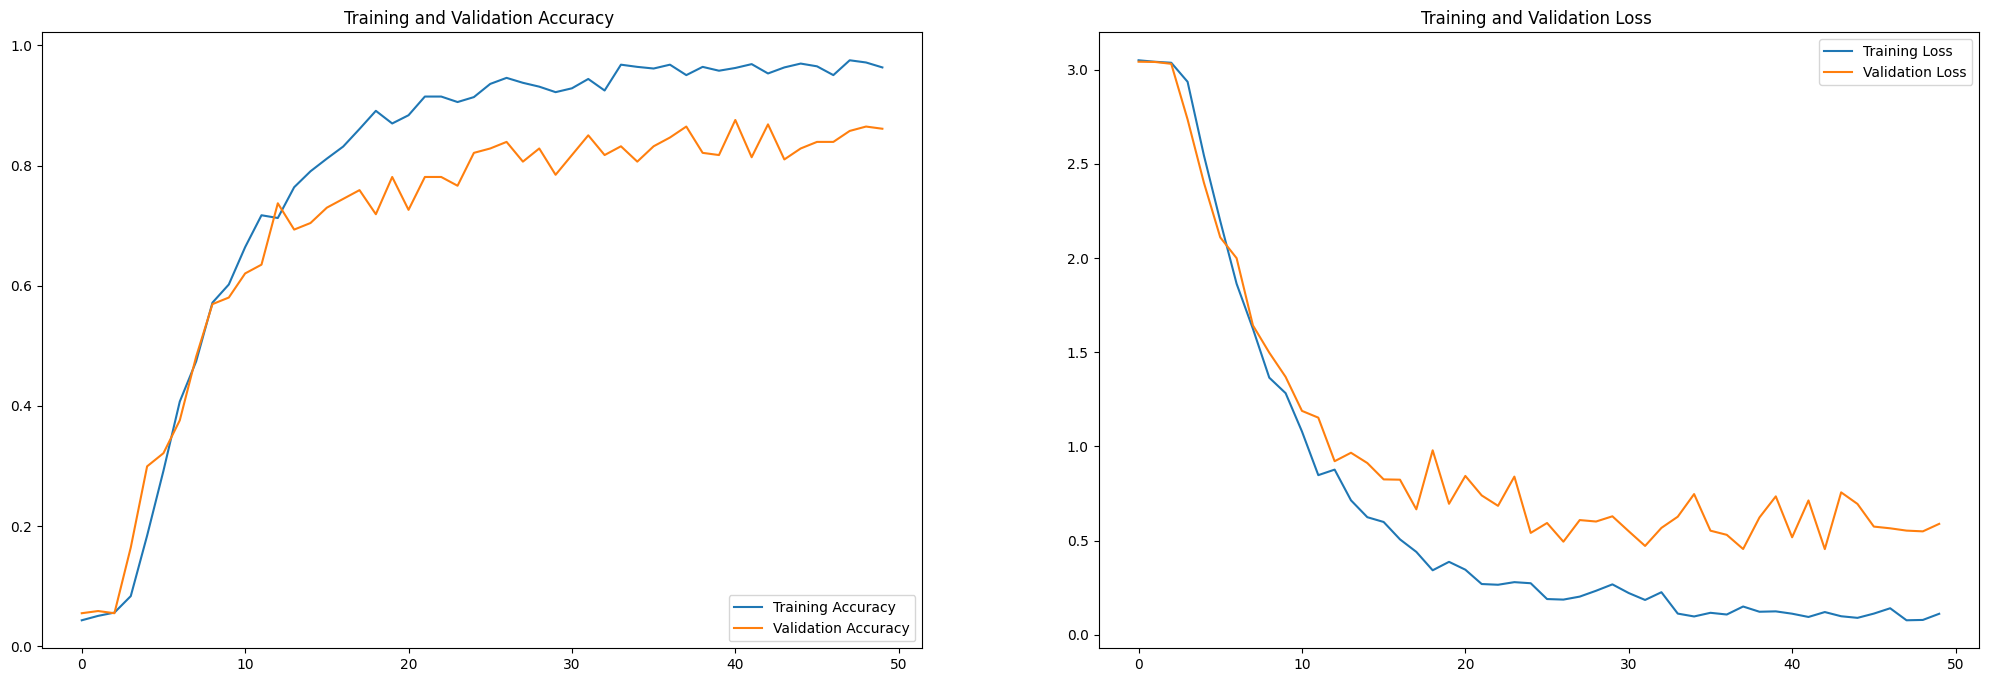

Test Accuracy 88.01169395446777
--------------------------------------------------
Fold No. 2
Found 1093 validated image filenames belonging to 21 classes.
Found 274 validated image filenames belonging to 21 classes.
Epoch 1/50
35/35 [==============================] - 7s 62ms/step - loss: 3.0483 - accuracy: 0.0503 - val_loss: 3.0425 - val_accuracy: 0.0620
Epoch 2/50
35/35 [==============================] - 2s 53ms/step - loss: 3.0396 - accuracy: 0.0595 - val_loss: 3.0377 - val_accuracy: 0.1022
Epoch 3/50
35/35 [==============================] - 2s 52ms/step - loss: 2.9987 - accuracy: 0.0823 - val_loss: 2.9111 - val_accuracy: 0.0803
Epoch 4/50
35/35 [==============================] - 2s 52ms/step - loss: 2.6907 - accuracy: 0.1647 - val_loss: 2.5348 - val_accuracy: 0.2591
Epoch 5/50
35/35 [==============================] - 2s 71ms/step - loss: 2.3532 - accuracy: 0.3047 - val_loss: 2.1073 - val_accuracy: 0.3540
Epoch 6/50
35/35 [==============================] - 3s 73ms/step - loss: 1.910

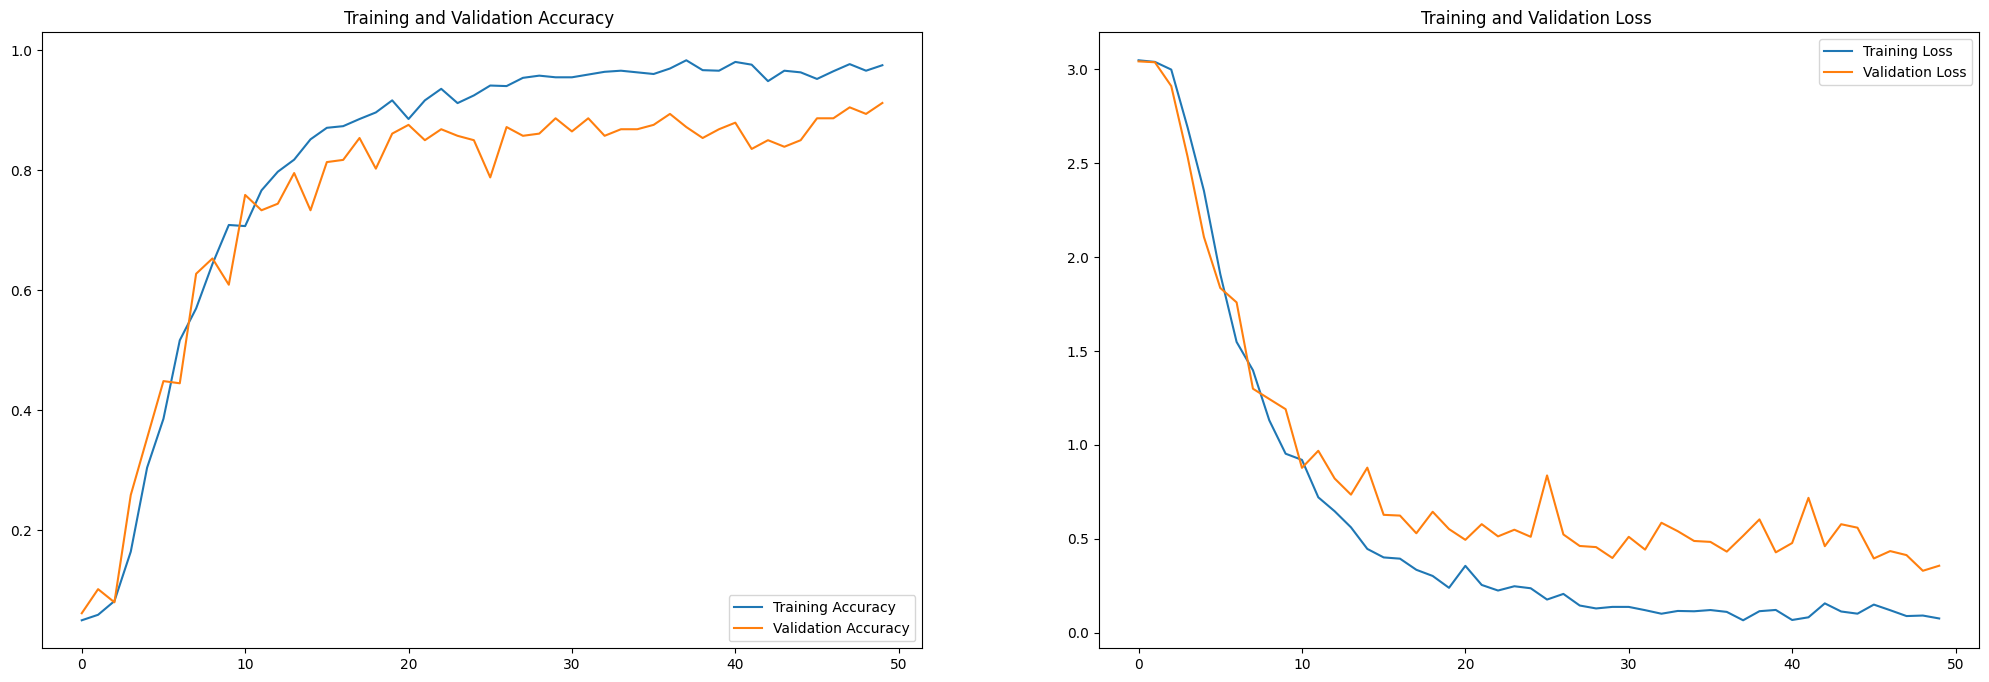

Test Accuracy 92.39766001701355
--------------------------------------------------
Fold No. 3
Found 1094 validated image filenames belonging to 21 classes.
Found 273 validated image filenames belonging to 21 classes.
Epoch 1/50
35/35 [==============================] - 8s 94ms/step - loss: 3.0497 - accuracy: 0.0503 - val_loss: 3.0424 - val_accuracy: 0.0549
Epoch 2/50
35/35 [==============================] - 2s 53ms/step - loss: 3.0424 - accuracy: 0.0521 - val_loss: 3.0405 - val_accuracy: 0.0549
Epoch 3/50
35/35 [==============================] - 2s 54ms/step - loss: 3.0426 - accuracy: 0.0503 - val_loss: 3.0405 - val_accuracy: 0.0623
Epoch 4/50
35/35 [==============================] - 2s 54ms/step - loss: 3.0403 - accuracy: 0.0622 - val_loss: 3.0331 - val_accuracy: 0.0623
Epoch 5/50
35/35 [==============================] - 3s 74ms/step - loss: 3.0351 - accuracy: 0.0649 - val_loss: 3.0201 - val_accuracy: 0.0879
Epoch 6/50
35/35 [==============================] - 2s 54ms/step - loss: 3.014

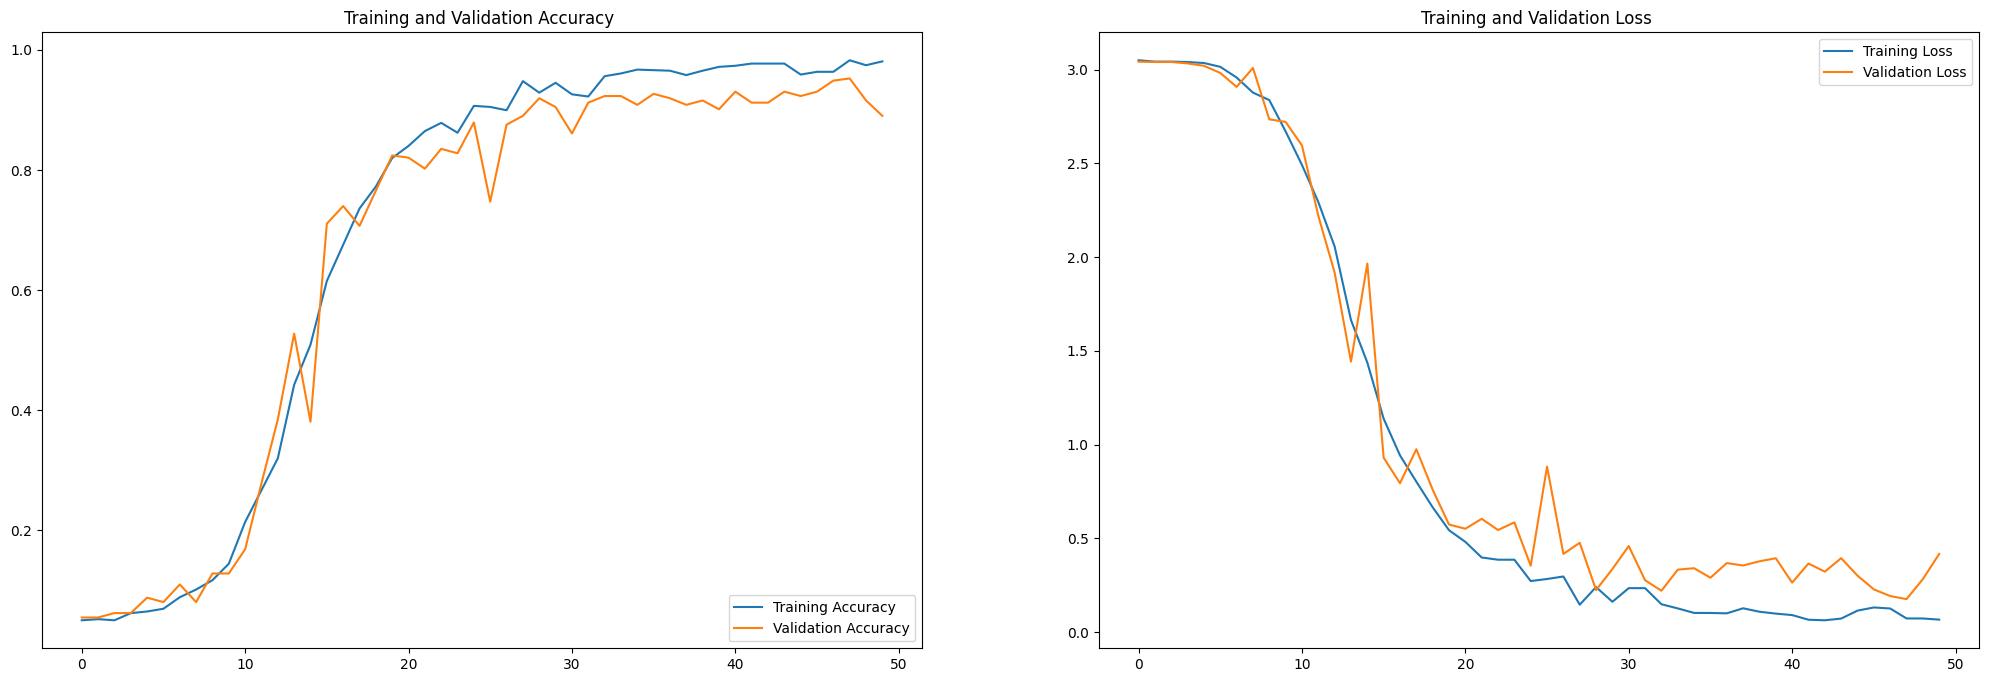

Test Accuracy 88.88888955116272
--------------------------------------------------
Fold No. 4
Found 1094 validated image filenames belonging to 21 classes.
Found 273 validated image filenames belonging to 21 classes.
Epoch 1/50
35/35 [==============================] - 6s 69ms/step - loss: 3.0484 - accuracy: 0.0484 - val_loss: 3.0418 - val_accuracy: 0.0549
Epoch 2/50
35/35 [==============================] - 2s 52ms/step - loss: 3.0436 - accuracy: 0.0475 - val_loss: 3.0414 - val_accuracy: 0.0623
Epoch 3/50
35/35 [==============================] - 2s 52ms/step - loss: 3.0408 - accuracy: 0.0603 - val_loss: 3.0372 - val_accuracy: 0.0623
Epoch 4/50
35/35 [==============================] - 2s 55ms/step - loss: 3.0389 - accuracy: 0.0603 - val_loss: 3.0360 - val_accuracy: 0.0623
Epoch 5/50
35/35 [==============================] - 3s 84ms/step - loss: 3.0393 - accuracy: 0.0667 - val_loss: 3.0369 - val_accuracy: 0.0623
Epoch 6/50
35/35 [==============================] - 2s 55ms/step - loss: 2.989

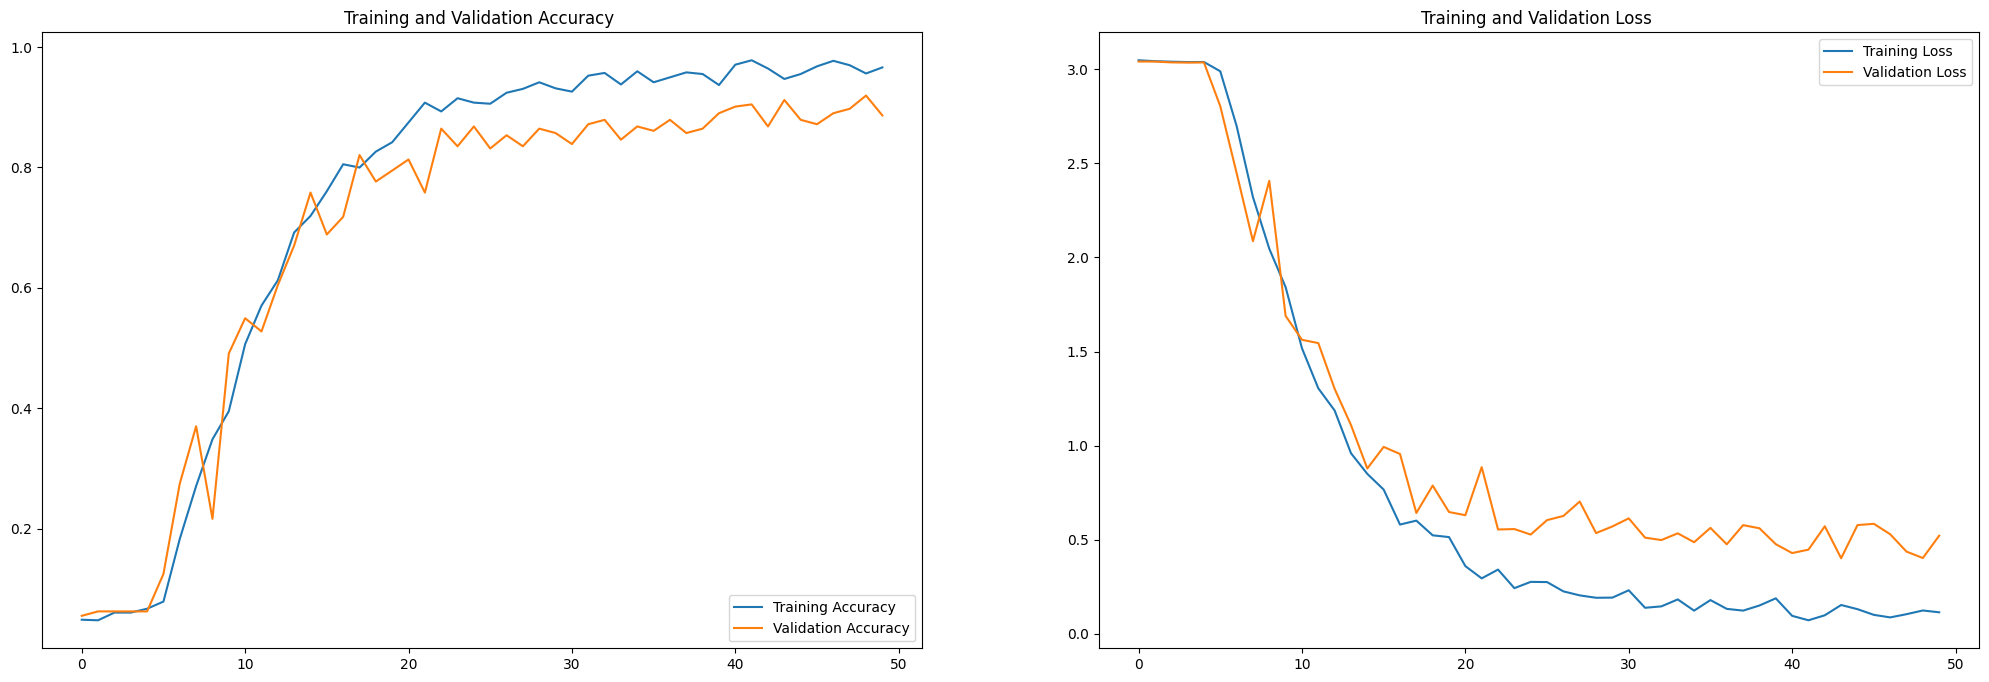

Test Accuracy 93.56725215911865
--------------------------------------------------
Fold No. 5
Found 1094 validated image filenames belonging to 21 classes.
Found 273 validated image filenames belonging to 21 classes.
Epoch 1/50
35/35 [==============================] - 5s 62ms/step - loss: 3.0485 - accuracy: 0.0420 - val_loss: 3.0418 - val_accuracy: 0.0586
Epoch 2/50
35/35 [==============================] - 2s 56ms/step - loss: 3.0399 - accuracy: 0.0603 - val_loss: 3.0411 - val_accuracy: 0.0586
Epoch 3/50
35/35 [==============================] - 2s 59ms/step - loss: 3.0396 - accuracy: 0.0548 - val_loss: 3.0412 - val_accuracy: 0.0586
Epoch 4/50
35/35 [==============================] - 3s 82ms/step - loss: 3.0415 - accuracy: 0.0612 - val_loss: 3.0398 - val_accuracy: 0.0586
Epoch 5/50
35/35 [==============================] - 2s 55ms/step - loss: 3.0381 - accuracy: 0.0622 - val_loss: 3.0330 - val_accuracy: 0.0842
Epoch 6/50
35/35 [==============================] - 2s 55ms/step - loss: 3.038

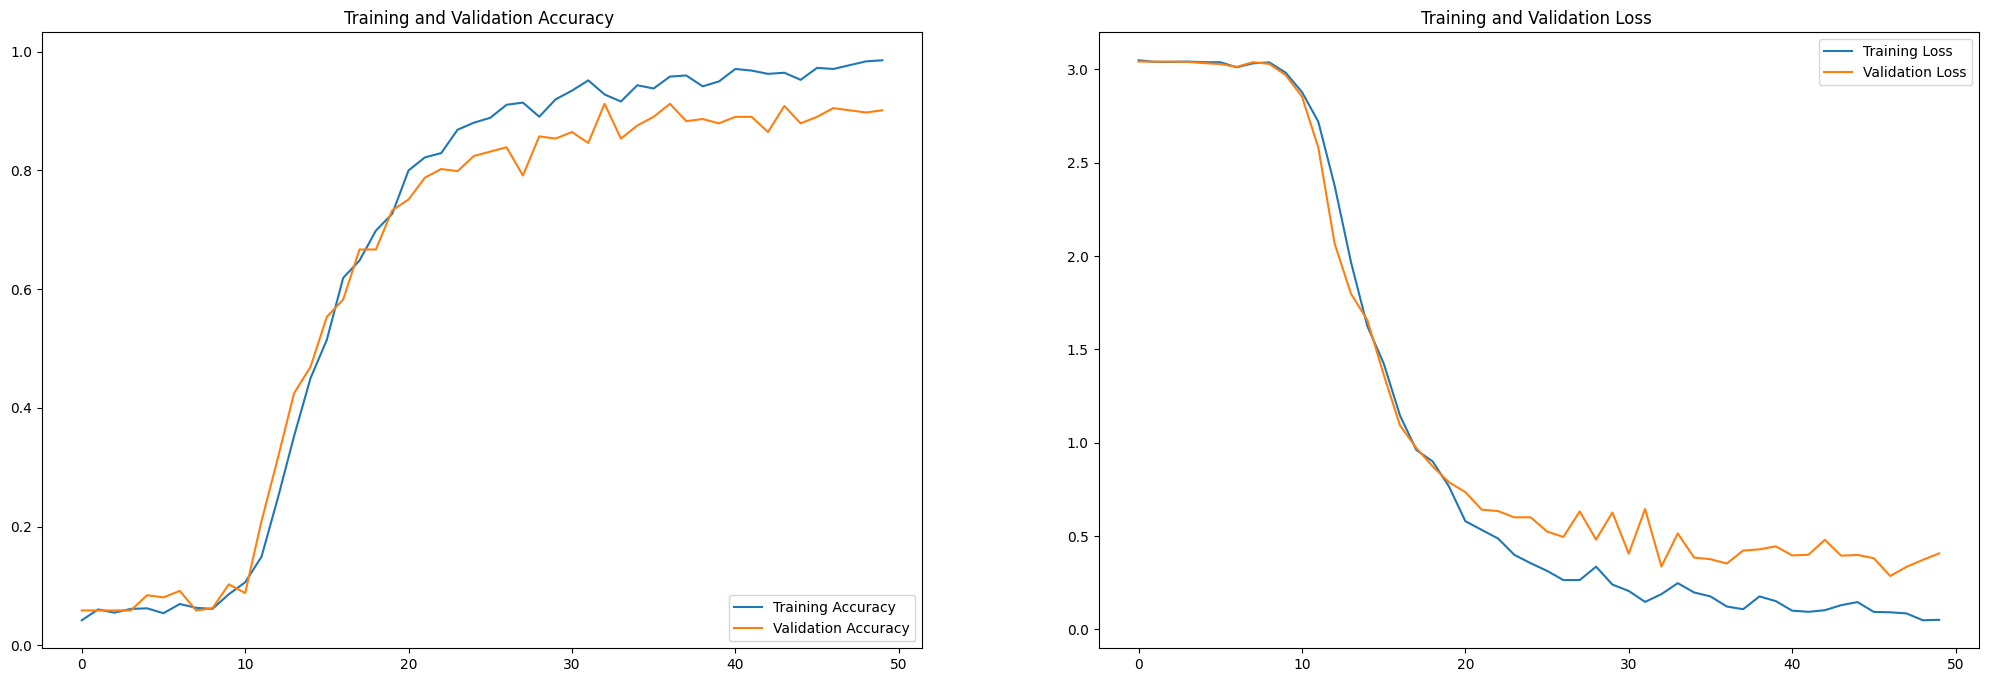

Test Accuracy 91.22806787490845
--------------------------------------------------


In [ ]:
for train_idx, val_idx in kfold.split(X, Y):
    train_df = train_dataframe.iloc[train_idx]
    valid_df = train_dataframe.iloc[val_idx]
    print(f'Fold No. {fold_no}')

    training_set = datagen.flow_from_dataframe(dataframe=train_df, directory=dataset_path_img,
                        x_col='image', y_col='label',
                        target_size=(IMG_H, IMG_W), batch_size=BATCH_SIZE)

    validation_set = datagen.flow_from_dataframe(dataframe=valid_df, directory=dataset_path_img,
                        x_col='image', y_col='label',
                        target_size=(IMG_H, IMG_W), batch_size=BATCH_SIZE)

    model = create_model(NO_CLASSES)
    history = model.fit(training_set, validation_data=validation_set,
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    df = pd.DataFrame(data={ 'training_acc': train_acc, 'val_acc': val_acc, 'training_loss': train_loss, 'val_loss': val_loss })
    df.to_csv(f'CNN_Model_F_{fold_no}.csv')

    plot_accuracy(history, fold_no)

    model.save('content/model_fold_' + str(fold_no), save_format="h5")

    scores = model.evaluate(test_set, verbose=0)
    test_acc = scores[1] * 100
    acc_per_fold.append(test_acc)

    print(f'Test Accuracy {test_acc}')
    print('-----'*10)

    fold_no += 1

In [ ]:
for idx, acc in enumerate(acc_per_fold):
    print(f'Accuracy for fold no. {idx+1} is: {acc}')

Accuracy for fold no. 1 is: 88.01169395446777
Accuracy for fold no. 2 is: 92.39766001701355
Accuracy for fold no. 3 is: 88.88888955116272
Accuracy for fold no. 4 is: 93.56725215911865
Accuracy for fold no. 5 is: 91.22806787490845


In [ ]:
acc_arr = np.array(acc_per_fold)

In [ ]:
acc_mean = acc_arr.mean()
acc_mean

90.81871271133423

In [ ]:
acc_std = acc_arr.std()
acc_std

2.088956058466449

In [ ]:
print(f'Accuracy in between {acc_mean-acc_std} to {acc_mean+acc_std}')

Accuracy in between 88.72975665286778 to 92.90766876980068
